In [16]:
import datetime
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from transformers import BertTokenizer
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import re
from collections import Counter

In [17]:
import nltk

nltk.download("wordnet")
nltk.download("punkt")
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\agupt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agupt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\agupt\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agupt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\agupt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
# Load Data
train = pd.read_csv('../public_data/train/track_a/eng.csv')
val = pd.read_csv('../public_data/dev/track_a/eng_a.csv')
emotions = ['Joy', 'Sadness', 'Surprise', 'Fear', 'Anger']

train.describe()

,Anger,Fear,Joy,Sadness,Surprise
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000
mean,0.120303,0.582009,0.243497,0.317197,0.303107
std,0.325375,0.493318,0.429270,0.465469,0.459684
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2768 non-null   object
 1   text      2768 non-null   object
 2   Anger     2768 non-null   int64 
 3   Fear      2768 non-null   int64 
 4   Joy       2768 non-null   int64 
 5   Sadness   2768 non-null   int64 
 6   Surprise  2768 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 151.5+ KB


In [20]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        116 non-null    object 
 1   text      116 non-null    object 
 2   Anger     0 non-null      float64
 3   Fear      0 non-null      float64
 4   Joy       0 non-null      float64
 5   Sadness   0 non-null      float64
 6   Surprise  0 non-null      float64
dtypes: float64(5), object(2)
memory usage: 6.5+ KB


In [21]:
# Preprocessing Config
config = {'sep_pn': True, 'rm_pn': False, 'apply_lemmatization': True, 'apply_stemming': True, 'add_bigrams': True, 'rm_sw': False}

# Preprocessing Functions
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nlp = spacy.load("en_core_web_sm")

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Get English stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
def pre_process(text, config):
    def separate_punctuation(text):
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
        return text

    def remove_punctuation(text):
        text = re.sub(r"[.,;:!?'\"“”\(\)]", "", text)
        return text

    def tokenize_text(text):
        encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        return tokens

    def apply_stemming(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def apply_lemmatization(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    def generate_ngrams_from_tokens(tokens, n):
        return [" ".join(gram) for gram in ngrams(tokens, n)]

    def filter_text_dynamic(text):
        # Lowercase and remove punctuation
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        
        # Score words based on sentiment
        words = text.split()
        relevant_words = [
            word for word in words
            if word not in stop_words and sia.polarity_scores(word)['pos'] > 0.5  # Adjust threshold as needed
        ]
        
        return " ".join(relevant_words)

    def remove_top_words(text, top_n=10):
        # Count word frequencies
        word_counts = Counter(text.split())
        
        # Identify the top N words
        top_words = [word for word, _ in word_counts.most_common(top_n)]
        
        # Filter out top words from text
        filtered_text = " ".join(word for word in text.split() if word not in top_words)
        
        return filtered_text
    
    
    filtered_text = filter_text_dynamic(text)
    
    # Remove top words from the filtered text
    text = remove_top_words(filtered_text, top_n=8)

    # Apply config options
    if config['sep_pn'] and not config['rm_pn']:
        text = separate_punctuation(text)
    if config['rm_pn'] and not config['sep_pn']:
        text = remove_punctuation(text)

    tokens = tokenize_text(text)
    if config['apply_stemming']:
        tokens = apply_stemming(tokens)
    if config['apply_lemmatization']:
        tokens = apply_lemmatization(tokens)
    if config['add_bigrams']:
        tokens += generate_ngrams_from_tokens(tokens, 2)
    if config['rm_sw']:
        tokens = [word for word in tokens if word.lower() not in stop_words]

    return " ".join(tokens)

# Preprocess and Extract Features
vectorizer = CountVectorizer()

train_text = [pre_process(text, config) for text in train["text"]]
val_text = [pre_process(text, config) for text in val["text"]]

X_train = vectorizer.fit_transform(train_text).toarray()
X_val = vectorizer.transform(val_text).toarray()

# POS Tagging
def extract_pos_tags(texts):
    return [[token.pos_ for token in nlp(text)] for text in texts]

train_pos_tags = extract_pos_tags(train["text"])
val_pos_tags = extract_pos_tags(val["text"])

# POS Encoding
max_length = max(max(len(tags) for tags in train_pos_tags), max(len(tags) for tags in val_pos_tags))
train_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in train_pos_tags]
val_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in val_pos_tags]

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_pos_encoded = encoder.fit_transform(train_pos_tags)
val_pos_encoded = encoder.transform(val_pos_tags)

# Combine Features
combined_features = np.concatenate((X_train, train_pos_encoded), axis=1)
validation_combined_features = np.concatenate((X_val, val_pos_encoded), axis=1)

# Logistic Regression for Enhanced Features
y_train = train[emotions].values
lr = LogisticRegression(max_iter=1000)
lr.fit(combined_features, np.argmax(y_train, axis=1))

lr_features = lr.predict_proba(combined_features)
val_lr_features = lr.predict_proba(validation_combined_features)

final_train_features = np.concatenate((combined_features, lr_features), axis=1)
final_val_features = np.concatenate((validation_combined_features, val_lr_features), axis=1)

# Neural Network
model = nn.Sequential(
    nn.Linear(final_train_features.shape[1], 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
)

# DataLoader
features_tensor = torch.tensor(final_train_features, dtype=torch.float32)
labels_tensor = torch.tensor(y_train, dtype=torch.float32)
dataset = TensorDataset(features_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

weights = y_train.sum(axis=0)/y_train.sum()
weights = max(weights)/weights

# Loss and Optimizer
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(weights)) # <-- weights assigned to optimiser
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-4) # lr=1e-4

# Training Loop
losses = []
for epoch in tqdm(range(401), desc="Training Loop"):
    for features, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # if epoch % 100 == 0:
    #     print(f"Epoch {epoch}: Loss: {round(loss.item(), 3)}")
    # losses.append(loss.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss: {round(loss.item(),3)}')
        # Save the trained model's weights for future use.
        torch.save(model.state_dict(), f'./28-12-24/net_epoch_{epoch}.pth')
        print(f"Saved epoch {epoch} weights to './28-12-24/net_epoch_{epoch}.pth'")
        losses.append(round(loss.item(),3))
    if epoch == 400:
        print(f'Epoch {epoch}: Loss: {round(loss.item(),3)}')
        # Save the trained model's weights for future use.
        torch.save(model.state_dict(), f'./28-12-24/net_epoch_{epoch}.pth')
        print(f"Saved epoch {epoch} weights to './28-12-24/net_epoch_{epoch}.pth'")
        losses.append(round(loss.item(),3))

Training Loop:   0%|          | 1/400 [00:01<07:58,  1.20s/it]

Epoch 0: Loss: 0.866
Saved epoch 0 weights to './28-12-24/net_epoch_0.pth'


Training Loop:  25%|██▌       | 101/400 [01:38<04:53,  1.02it/s]

Epoch 100: Loss: 0.953
Saved epoch 100 weights to './28-12-24/net_epoch_100.pth'


Training Loop:  50%|█████     | 201/400 [03:30<03:49,  1.15s/it]

Epoch 200: Loss: 0.854
Saved epoch 200 weights to './28-12-24/net_epoch_200.pth'


Training Loop:  75%|███████▌  | 301/400 [05:22<01:59,  1.21s/it]

Epoch 300: Loss: 0.869
Saved epoch 300 weights to './28-12-24/net_epoch_300.pth'


Training Loop: 100%|██████████| 400/400 [06:54<00:00,  1.04s/it]


In [23]:
# Final Loss
print(f"Final Loss after 400 epochs: {losses[-1]}")

Final Loss after 400 epochs: 0.869


In [24]:
final_val_features, losses

(array([[2.00000000e+00, 2.00000000e+00, 0.00000000e+00, ...,
         9.72431924e-02, 8.20620133e-02, 2.41632159e-03],
        [2.00000000e+00, 2.00000000e+00, 0.00000000e+00, ...,
         4.20778798e-02, 3.80786596e-01, 2.05603399e-03],
        [2.00000000e+00, 2.00000000e+00, 0.00000000e+00, ...,
         1.21560692e-02, 7.75566496e-04, 8.83292122e-04],
        ...,
        [2.00000000e+00, 2.00000000e+00, 0.00000000e+00, ...,
         2.07497895e-01, 1.09930734e-01, 9.31251721e-03],
        [2.00000000e+00, 2.00000000e+00, 0.00000000e+00, ...,
         1.47244021e-01, 1.85247861e-01, 2.16231444e-02],
        [2.00000000e+00, 2.00000000e+00, 0.00000000e+00, ...,
         1.86241264e-01, 1.96467068e-01, 3.95471003e-02]]),
 [0.866, 0.953, 0.854, 0.869])

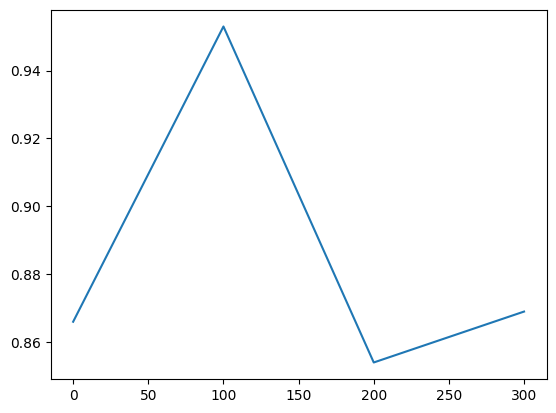

In [25]:
import matplotlib.pyplot as plt

eps = [100*i for i in range(0,4)]

plt.plot(eps, losses)

In [26]:
def get_predictions(X_val, model, threshold=0.5):
    sig = nn.Sigmoid() 
    yhat = sig(model(X_val)).detach().numpy()
    y_pred = yhat > threshold
    
    return y_pred

# y_pred = get_predictions(torch.Tensor(final_val_features), model, 0.45)
# # print(y_pred)

# # Create a DataFrame to save to CSV
# val_data_with_pred = pd.DataFrame(y_pred, columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])  # Adjust column names as per your features
# # val_data_with_pred['True_Label'] = y_test
# # val_data_with_pred['Predictions'] = dummy_predictions

# val_data_with_pred = val_data_with_pred.astype(int)

# val_data_with_pred['id'] = val['id']

# val_data_with_pred = val_data_with_pred[['id', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

# # Save to CSV
# current_time = datetime.datetime.now()
# formatted_time = current_time.strftime('%Y-%m-%d_%H_%M_%S')

# val_data_with_pred.to_csv(f'../results/pred_eng_a_{formatted_time}.csv', index=False)

# print(val_data_with_pred)

In [28]:
# DO 10 different prediction files with epochs 100, 200, 300, 400, 500, 600, 700, 800, 900 and 1000 Model parameters

# Get 10 differen prediction files

for i in range(4):
    epoch = i*100
    model.load_state_dict(torch.load(f'./28-12-24/net_epoch_{epoch}.pth', weights_only=True))
    y_pred = get_predictions(torch.Tensor(final_val_features), model, 0.45)
    # print(y_pred)

    # Create a DataFrame to save to CSV
    val_data_with_pred = pd.DataFrame(y_pred, columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])  # Adjust column names as per your features
    # val_data_with_pred['True_Label'] = y_test
    # val_data_with_pred['Predictions'] = dummy_predictions

    val_data_with_pred = val_data_with_pred.astype(int)

    val_data_with_pred['id'] = val['id']

    val_data_with_pred = val_data_with_pred[['id', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

    # Save to CSV
    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime('%Y-%m-%d_%H_%M_%S')

    val_data_with_pred.to_csv(f'../results/alt5_0/alt5_epoch_{epoch}_pred_eng_a_{formatted_time}.csv', index=False)

    print(val_data_with_pred)

                        id  Anger  Fear  Joy  Sadness  Surprise
0    eng_dev_track_a_00001      1     0    1        1         1
1    eng_dev_track_a_00002      1     1    1        1         1
2    eng_dev_track_a_00003      1     1    1        1         1
3    eng_dev_track_a_00004      1     0    1        1         1
4    eng_dev_track_a_00005      1     1    0        1         1
..                     ...    ...   ...  ...      ...       ...
111  eng_dev_track_a_00112      1     0    1        1         1
112  eng_dev_track_a_00113      1     1    0        1         1
113  eng_dev_track_a_00114      1     1    1        1         1
114  eng_dev_track_a_00115      0     1    1        1         1
115  eng_dev_track_a_00116      1     1    1        1         1

[116 rows x 6 columns]
                        id  Anger  Fear  Joy  Sadness  Surprise
0    eng_dev_track_a_00001      0     0    1        1         1
1    eng_dev_track_a_00002      1     1    1        1         1
2    eng_dev_tra

---

1. For Submission 5 files:

    Your results for eng track A are:

    Multi-label accuracy (Jaccard score): 0.26063218390804593

    Micro F1 score: 0.41758241758241754

    Macro F1 score: 0.36549662349391404

2. For Submission 6 files:

    Your results for eng track A are:

    Multi-label accuracy (Jaccard score): 0.26206896551724135

    Micro F1 score: 0.42659279778393355

    Macro F1 score: 0.36911780259117266

3. For Submission 8 files

| Epoch | Jaccard Index       | Micro F1            | Macro F1            |
| ----- | ------------------- | ------------------- | ------------------- |
| 0     | 0.29094827586206906 | 0.4409171075837742  | 0.3952511404048909  |
| 100   | 0.24080459770114943 | 0.39560439560439564 | 0.3420526643168152  |
| 200   | 0.2548850574712644  | 0.4089635854341737  | 0.3569574389199279  |
| 300   | 0.2548850574712644  | 0.41758241758241754 | 0.3576650885346538  |
| 400   | 0.2557471264367816  | 0.4098360655737705  | 0.3598377304037682  |
| 500   | 0.2530172413793103  | 0.41666666666666663 | 0.35474739097380603 |
| 600   | 0.26379310344827583 | 0.41208791208791207 | 0.3499361424130125  |
| 700   | 0.27241379310344827 | 0.42622950819672134 | 0.37301587301587297 |
| 800   | 0.253448275862069   | 0.4098360655737705  | 0.3496649512518185  |
| 900   | 0.25804597701149423 | 0.41961852861035426 | 0.37158938378169115 |

---

1. ALT 5 Epoch 0: 

Multi-label accuracy (Jaccard score): 0.26954022988505744

Micro F1 score: 0.4201438848920864

Macro F1 score: 0.40864974517443786

2. ALT 5 Epoch 100: 

Multi-label accuracy (Jaccard score): 0.3070402298850575

Micro F1 score: 0.4602649006622517

Macro F1 score: 0.4274557175116834

3. ALT 5 Epoch 200: 

Multi-label accuracy (Jaccard score): 0.2689655172413793

Micro F1 score: 0.4114285714285714

Macro F1 score: 0.36944836989062213

4. ALT 5 Epoch 300: 

Multi-label accuracy (Jaccard score): 0.25244252873563217

Micro F1 score: 0.3869653767820774

Macro F1 score: 0.320969520516741